<a href="https://colab.research.google.com/github/Masterak25/ML_AK/blob/main/nyc_bb_bicyclist_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# counts of bicyclists traveling over various NYC bridges 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# IMPORTING DATASET

In [2]:
df=pd.read_csv("/content/nyc_bb_bicyclist_counts.csv", header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807


In [3]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

In [4]:
df.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5


In [5]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=168
Testing data set length=46


Setup the regression expression in patsy notation. We are telling patsy that BB_COUNT is our dependent variable and it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP.

In [6]:
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

Set up the X and y matrices for the training and testing data sets

In [7]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

Using the statsmodels GLM class, train the Poisson regression model on the training data set.

In [8]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [9]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  168
Model:                            GLM   Df Residuals:                      161
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10577.
Date:                Sun, 24 Oct 2021   Deviance:                       19529.
Time:                        20:00:51   Pearson chi2:                 1.92e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.1708      0.014    529.166      

The reported values of Deviance and Pearson chi-squared are very large. A good fit is virtually impossible given these values. To make a quantitative determination of the goodness-of-fit at some confidence level, say 95% (p=0.05), we look up the value in the χ2 table for p=0.05 and Degrees of freedom of residuals=161. (DF Residuals = No. Observations minus DF model]). We compare this Chi-Squared value with the observed statistic, in this case, the Deviance or the Pearson’s chi-squared value reported in GLMResults. We find that at p=0.05 and DF Residuals = 161, the chi-squared value from a standard Chi-Squared table is 191.608 which is much smaller than the reported statistic of 19529 and 19200. Hence as per this test, the Poisson regression model, in spite of demonstrating an ‘okay’ visual fit for the test data set, has fit the training data rather poorly.

In [10]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                   mean    mean_se  mean_ci_lower  mean_ci_upper
Date                                                            
2017-04-01  1988.909944  12.395656    1964.762687    2013.353974
2017-04-02  2622.535141  15.020172    2593.260760    2652.139989
2017-04-06  1248.993775   8.259791    1232.909348    1265.288039
2017-04-13  2636.524088   9.443745    2618.079508    2655.098611
2017-04-19  2181.128287  10.657041    2160.340566    2202.116036
2017-04-20  2358.360953   8.579496    2341.605257    2375.236547
2017-04-22  1882.643238   9.478335    1864.157398    1901.312392
2017-04-26  1781.750365   8.427824    1765.308467    1798.345402
2017-04-27  2525.976837   9.734949    2506.968569    2545.129230
2017-04-28  3484.278100  19.204966    3446.839648    3522.123195
2017-05-03  2429.398832  10.422383    2409.056979    2449.912450
2017-05-04  2548.252436   9.285778    2530.117484    2566.517373
2017-05-09  2630.520767   9.852354    2611.281211    2649.902077
2017-05-11  2390.808769  

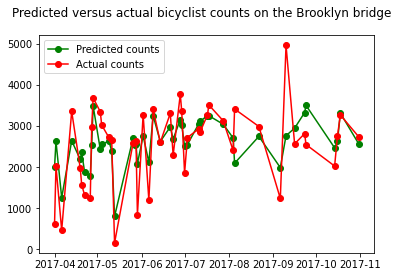

In [11]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

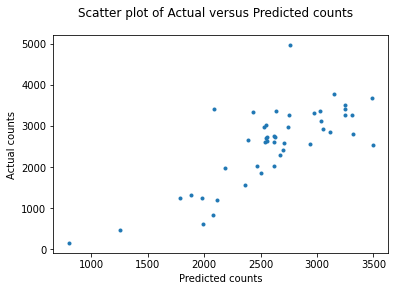

In [12]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

another Implementation:
When I was searching for the information about Poisson Regression online. I was able to find and understand the theory but not the implementation. So, I have done a lot of research and I’m providing you with the implementation.
Surprise! Poisson Regressor is now available in scikit-learn library itself!
Upgrade it if you haven’t already and implement

!pip install --upgrade scikit-learn

In [13]:
#pip show sklearn

In [14]:
#!pip install sklearn --upgrade

In [15]:
#!pip install --upgrade scikit-learn

# poisson_regression_application
Features of count based data

Regression models for seasonal forecasting counts

In [16]:
from sklearn.linear_model import PoissonRegressor
pr = PoissonRegressor()
pr.fit(X_train, y_train)
y_pr = pr.predict(X_test)

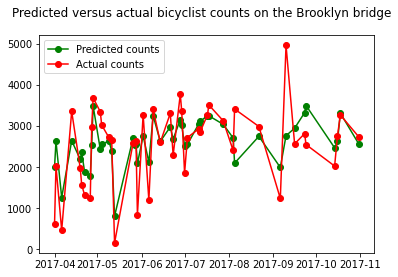

In [26]:
predicted_counts=y_pr
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [25]:
f_comp = pd.DataFrame({"GLM_predict":predictions_summary_frame['mean'] , "M_Predicted": y_pr}) 
f_comp.head()

,GLM_predict,M_Predicted
Date,,
2017-04-01,1988.909944,1991.809840
2017-04-02,2622.535141,2624.946099
2017-04-06,1248.993775,1254.329206
2017-04-13,2636.524088,2637.933167
2017-04-19,2181.128287,2183.003641


In [18]:
from sklearn.metrics import mean_squared_error
mse_p=mean_squared_error(y_test, y_pr)
mse_p

422530.43179241614

In [19]:
from math import sqrt
rms_p = sqrt(mean_squared_error(y_test, y_pr))
rms_p

650.0234086495778

In [20]:
from sklearn.metrics import r2_score
r2_p = r2_score(y_test, y_pr)
print('r2 score for poisson regression model is', r2_p *100)

r2 score for poisson regression model is 54.17351204561527


In [21]:
from sklearn.metrics import mean_squared_error
mse_GLM=mean_squared_error(y_test, predictions_summary_frame['mean'])
mse_GLM

421813.5280174386

In [22]:
from math import sqrt
rms_GLM = sqrt(mean_squared_error(y_test, predictions_summary_frame['mean']))
rms_GLM

649.4717299601566

In [23]:
from sklearn.metrics import r2_score
r2_GLM = r2_score(y_test, predictions_summary_frame['mean'])
print('r2 score for GLM poisson model is', r2_GLM *100)

r2 score for GLM poisson model is 54.2512654563438


In [24]:
data = {'MSE':[mse_p,mse_GLM],'RMS':[rms_p,rms_GLM],'ACCURACY':[r2_p*100,r2_GLM*100]}
df = pd.DataFrame(data)
df = pd.DataFrame(data, index=['statsmodels GLM_POISSON_REGRESSION','POISSON_REGRESSION'])
df

,MSE,RMS,ACCURACY
statsmodels GLM_POISSON_REGRESSION,422530.431792,650.023409,54.173512
POISSON_REGRESSION,421813.528017,649.471730,54.251265


# Conclusion and next steps
For counts based data, a useful starting point is the Poisson regression model. One can then compare its performance with other popular counts based models, such as:

* The Negative Binomial regression model which does not make the mean = variance assumption about the data.
*Generalized Poisson regression models which also work well with over-dispersed or under-dispersed data sets.
* A Zero Inflated Poisson model if you suspect that your data contains excess zeros i.e. many more zeroes than what the regular Poisson model can explain.

      Both method of poisson regression model gives same result 

Happy modeling!